Dataset:
https://drive.google.com/drive/folders/1CBu4hgOJEVuONYfzN7EwU0bNPJpOblVZ?usp=sharing

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Preprocessing and Normalizing the Training Dataset**

In [14]:
import tensorflow
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1.0/255,              # Normalize pixel values
    validation_split=0.2,
    rotation_range=40,            # Randomly rotate images
    width_shift_range=0.2,        # Randomly shift images horizontally
    height_shift_range=0.2,       # Randomly shift images vertically
    shear_range=0.2,              # Shear transformations
    zoom_range=0.2,               # Random zoom
    horizontal_flip=True,         # Flip images horizontally
    fill_mode='nearest'           # Fill empty pixels after transformation
)

val_datagen = ImageDataGenerator(rescale=1.0/255,validation_split=0.2,)  # Validation data only normalized

train_generator = train_datagen.flow_from_directory(
    '/content/gdrive/MyDrive/Automating_Port_Operations_dataset',
    subset="training",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # Use 'categorical' for more than 2 classes
)

val_generator = val_datagen.flow_from_directory(
    '/content/gdrive/MyDrive/Automating_Port_Operations_dataset',
    subset="validation",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 934 images belonging to 9 classes.
Found 228 images belonging to 9 classes.


**Visualizing a Subset of Images from the Training Dataset**

In [25]:
import matplotlib.pyplot as plt

['buoy', 'cruise_ship', 'ferry_boat', 'freight_boat', 'gondola', 'inflatable_boat', 'kayak', 'paper_boat', 'sailboat']


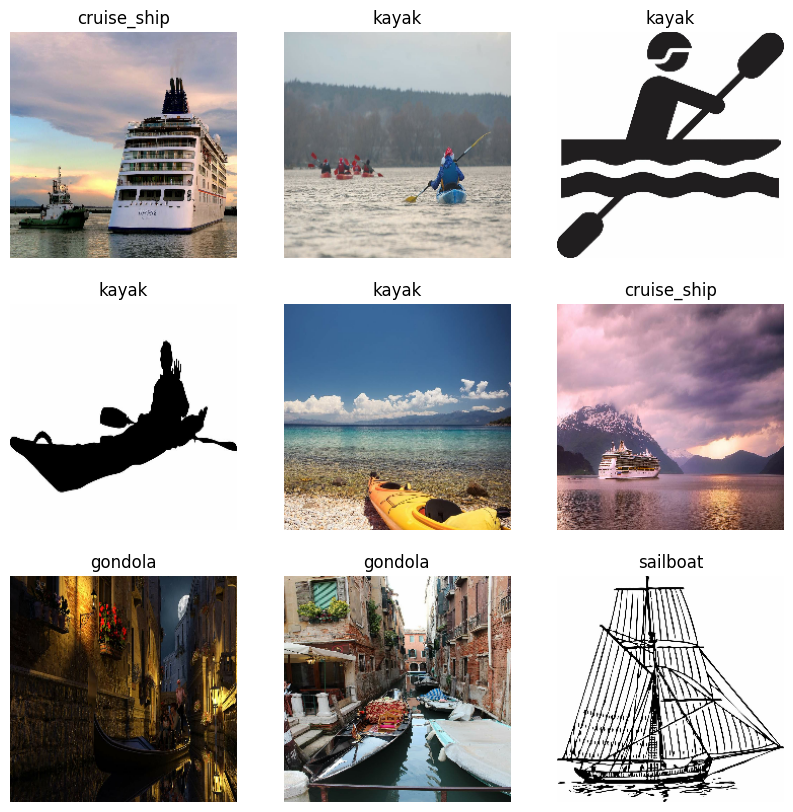

In [ ]:
class_names = train_generator.class_names
print(class_names)



plt.figure(figsize=(10, 10))
for images, labels in train_generator.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

**Creating a Convolutional Neural Network Model With Data Augmentation**
1.	Build a CNN network to classify the boat.

In [2]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50



# Load the pre-trained ResNet50 model without the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model to retain pre-trained features
base_model.trainable = False

# Create the custom model
x = base_model.output  # Get the output from ResNet50
x = layers.GlobalAveragePooling2D()(x)  # Apply global average pooling to reduce spatial dimensions
x = layers.Dense(128, activation='relu')(x)  # Add a dense layer with 128 units
x = layers.Dropout(0.5)(x)  # Add dropout for regularization
x = layers.Dense(9, activation='softmax')(x)  # Output layer with 9 classes and softmax activation

# Define the full model
model = models.Model(inputs=base_model.input, outputs=x)




94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Summarizing and Compiling the Model**

In [ ]:
model.summary()

In [ ]:
from keras import optimizers

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

**Training the Model**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_generator, validation_data=val_generator, epochs=20, callbacks=[early_stopping])


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 228s 7s/step - accuracy: 0.2538 - loss: 2.2452 - val_accuracy: 0.3377 - val_loss: 1.7775
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 258s 7s/step - accuracy: 0.3204 - loss: 1.8343 - val_accuracy: 0.3553 - val_loss: 1.7602
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 263s 7s/step - accuracy: 0.3190 - loss: 1.8257 - val_accuracy: 0.3772 - val_loss: 1.7808
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 260s 7s/step - accuracy: 0.3799 - loss: 1.7955 - val_accuracy: 0.3596 - val_loss: 1.7164
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 326s 9s/step - accuracy: 0.3837 - loss: 1.7246 - val_accuracy: 0.3553 - val_loss: 1.7271
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 281s 8s/step - accuracy: 0.3381 - loss: 1.7817 - val_accuracy: 0.3553 - val_loss: 1.7047
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 233s 8s/step - accuracy: 0.3042 - loss: 1.7965 - val_accuracy: 0.3640 - val_loss: 1.7096
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 235s 8s/step - accuracy: 0.3570 - loss: 1.7605 - val_accuracy: 0.3772 - v

**Evaluate the model on test images**

In [ ]:
model.evaluate(val_generator)

8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.3848 - loss: 1.6147


[1.643615484237671, 0.3684210479259491]

**2.	Build a lightweight model with the aim of deploying the solution on a mobile device using transfer learning. You can use any lightweight pre-trained model as the initial (first) layer. MobileNetV2 is a popular lightweight pre-trained model built using Keras API. **

In [18]:

from tensorflow.keras.applications import MobileNetV2

lite_model = MobileNetV2(
    weights='imagenet',
    include_top=False,  # Exclude the fully connected layer
    input_shape=(224, 224, 3)  # Input shape for MobileNetV2
)

# Freeze the base model to retain pre-trained features
lite_model.trainable = False

lite = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(9, activation='softmax')
])



In [19]:
lite.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [21]:
lite_history = lite.fit(
          train_generator,
          validation_data=val_generator,
          epochs = 20,
          )

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 352s 10s/step - accuracy: 0.2805 - loss: 2.0060 - val_accuracy: 0.3509 - val_loss: 1.7769
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 321s 9s/step - accuracy: 0.3114 - loss: 1.8350 - val_accuracy: 0.3640 - val_loss: 1.7324
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 331s 10s/step - accuracy: 0.3458 - loss: 1.7542 - val_accuracy: 0.3640 - val_loss: 1.7156
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 275s 8s/step - accuracy: 0.3632 - loss: 1.7804 - val_accuracy: 0.3772 - val_loss: 1.6972
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 301s 9s/step - accuracy: 0.3563 - loss: 1.7686 - val_accuracy: 0.3772 - val_loss: 1.6833
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 286s 9s/step - accuracy: 0.3269 - loss: 1.7567 - val_accuracy: 0.3728 - val_loss: 1.6857
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 242s 8s/step - accuracy: 0.3677 - loss: 1.7385 - val_accuracy: 0.3553 - val_loss: 1.6842
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 279s 9s/step - accuracy: 0.4027 - loss: 1.6961 - val_accuracy: 0.3860 - val_loss: 

In [22]:
lite.evaluate(val_generator)

8/8 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - accuracy: 0.3866 - loss: 1.5999


[1.6122498512268066, 0.37719297409057617]

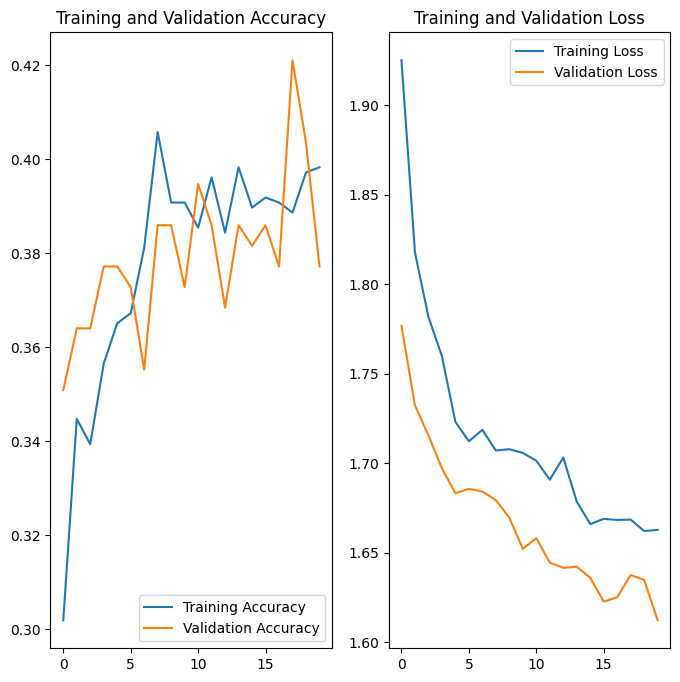

In [27]:
acc = lite_history.history['accuracy']
val_acc = lite_history.history['val_accuracy']

loss = lite_history.history['loss']
val_loss = lite_history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations:**

- The lightweight model correctly predicts a higher percentage of the outcomes than the first model.
-  The lightweight model has also fewer errors in its predictions than the first model.